<a href="https://colab.research.google.com/github/amedyukhina/AgrifieldNet/blob/main/agrinet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AgrifieldNet India Competition

## Install and import dependencies


In [1]:
%%writefile requirements.txt

pandas==1.3.5
scikit-learn==1.0.2
tqdm==4.64.0
rasterio==1.2.0
numpy==1.21.6
radiant_mlhub==0.4.1
torch==1.12.1
torchvision==0.13.1
scikit-image==0.18.3
matplotlib==3.2.2
pillow==7.1.2
monai==0.9.1
tensorboard==2.8.0

Overwriting requirements.txt


In [2]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
import json
import getpass
import rasterio
import numpy as np
import pandas as pd
from tqdm import tqdm
from radiant_mlhub import Dataset
import tarfile
import shutil
import numpy as np
import pandas as pd
import torch
import torch.utils.data
from torch import nn
from skimage import io
from torchvision import transforms as torch_transforms
import pylab as plt
from PIL import Image
from skimage.segmentation import mark_boundaries
from monai.networks.layers import Norm
from monai.networks.nets import UNet
from monai.losses import DiceLoss, DiceCELoss, MaskedDiceLoss
from monai.metrics import DiceMetric
# from torch.utils.tensorboard import SummaryWriter

## Specify global parameters

In [4]:
data_dir = 'data'
random_seed = 42

train_df_path = 'train_data.csv'

BAND_NAMES = ['B01', 'B02', 'B03', 'B04','B05', 'B06', 'B07', 'B08','B8A', 'B09', 'B11', 'B12']

In [5]:
np.random.seed(random_seed)

## Download data from MLHUB


In [6]:
collection_name = 'ref_agrifieldnet_competition_v1'

source_collection = f'{collection_name}_source'
train_label_collection = f'{collection_name}_labels_train'
test_label_collection = f'{collection_name}_labels_test'

In [7]:
if not os.path.exists(data_dir):
  os.environ['MLHUB_API_KEY'] =  getpass.getpass(prompt="MLHub API Key: ")

  dataset = Dataset.fetch(collection_name)
  dataset.download(output_dir=data_dir)
  for fn in os.listdir(data_dir):
    with tarfile.open(os.path.join(data_dir, fn)) as f:
      f.extractall(data_dir + '/') 
    os.remove(os.path.join(data_dir, fn))
else:
  print("Dataset already exists")

Dataset already exists


## Prepare Training data


### Create training dataframe

In [8]:
train_paths = os.listdir(os.path.join(data_dir, train_label_collection))
train_ids = [fn.split('_')[-1] for fn in train_paths if 'labels_train' in fn]

field_paths = [f'{data_dir}/{train_label_collection}/{train_label_collection}_{i}/field_ids.tif' 
               for i in train_ids]
label_paths = [f'{data_dir}/{train_label_collection}/{train_label_collection}_{i}/raster_labels.tif' 
               for i in train_ids]
source_paths = [f'{data_dir}/{source_collection}/{source_collection}_{i}/' 
               for i in train_ids]

In [9]:
train_data = pd.DataFrame(np.array([train_ids, field_paths, label_paths, source_paths]).transpose(), 
                          columns=['folder_id', 'field_path', 'label_path', 'source_path'])
train_data.head()

,folder_id,field_path,label_path,source_path
0,8a219,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_source/re...
1,b2361,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_source/re...
2,ae507,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_source/re...
3,39ea6,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_source/re...
4,001c1,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_source/re...



## Extract field-crop data

In [10]:
def extract_field_crop_data(data):
  field_ids = []
  crop_type = []
  field_area = []
  field_max_dim = []
  field_center_x = []
  field_center_y = []
  label_paths = []
  field_paths = []
  source_paths = []

  for i in tqdm(range(len(data))):
      with rasterio.open(data['field_path'].iloc[i]) as src:
          field_data = src.read()[0]
      with rasterio.open(data['label_path'].iloc[i]) as src:
          crop_data = src.read()[0]

      for field_id in np.unique(field_data)[1:]:
          ind = np.where(field_data == field_id)
          field_ids.append(field_id)
          crop_type.append(np.unique(crop_data[ind])[-1])
          field_area.append(len(ind[0]))
          field_max_dim.append(np.max(np.array(ind).max(1) - np.array(ind).min(1) + 1))
          field_center_y.append(np.mean(ind[0]))
          field_center_x.append(np.mean(ind[1]))
          label_paths.append(data['label_path'].iloc[i])
          field_paths.append(data['field_path'].iloc[i])
          source_paths.append(data['source_path'].iloc[i])

  df = pd.DataFrame(np.array([field_ids, crop_type, field_area, 
                              field_max_dim, field_center_x, 
                              field_center_y]).transpose(),
                    columns=['field_id', 'crop_type', 'field_area', 
                            'field_max_dim', 'center_x', 'center_y'])
  df['label_path'] = label_paths
  df['field_path'] = field_paths
  df['source_path'] = source_paths
  return df

In [11]:
df = extract_field_crop_data(train_data)

100%|██████████| 1165/1165 [00:13<00:00, 84.51it/s]


In [12]:
maxdim = df['field_max_dim'].max()
maxdim

54.0

In [13]:
size = 64

In [14]:
mean_area_fraction = np.mean(df['field_area']) / 256**2
mean_area_fraction

0.0004934933587038231

In [15]:
df = df.sort_values(['crop_type', 'field_id']).reset_index(drop=True)
df['count'] = 1

In [16]:
df.groupby('crop_type').sum()

,field_id,field_area,field_max_dim,center_x,center_y,count
crop_type,,,,,,
1.0,6241369.0,75118.0,17357.0,268141.027810,272345.129440,2148
2.0,3951325.0,46818.0,9542.0,134534.280499,135859.037956,1041
3.0,197850.0,2883.0,786.0,14378.647796,13225.595171,105
4.0,6633376.0,36397.0,10366.0,214265.322749,221002.721353,1707
5.0,53102.0,531.0,177.0,3473.416281,3866.649834,25
6.0,279015.0,5820.0,1451.0,22128.328845,21726.170139,173
8.0,255632.0,3150.0,526.0,5984.146869,6461.463742,49
9.0,2000157.0,8773.0,2275.0,37997.718876,38870.447163,304
13.0,360261.0,3503.0,647.0,6351.534183,7946.557215,64


### Split the data into train and validation

In [17]:
val_fraction = 0.2

In [18]:
df_train = []
df_val = []
for crop in df['crop_type'].unique():
    cur_df = df[df['crop_type'] == crop].reset_index(drop=True)
    unique_field_ids = cur_df['field_id'].unique()
    ind = np.arange(len(unique_field_ids))
    np.random.shuffle(ind)
    n_val = int(round(val_fraction * len(ind)))
    df_val.append(cur_df[cur_df['field_id'].isin(unique_field_ids[ind[:n_val]])])
    df_train.append(cur_df[cur_df['field_id'].isin(unique_field_ids[ind[n_val:]])])
df_train = pd.concat(df_train, ignore_index=True)
df_val = pd.concat(df_val, ignore_index=True)

In [19]:
n_fields = np.array(df_train.groupby('crop_type').sum()['count'])
weights = np.max(n_fields) / n_fields
crop_labels = np.unique(df_train['crop_type'])

In [20]:
crop_labels, weights

(array([ 1.,  2.,  3.,  4.,  5.,  6.,  8.,  9., 13., 14., 15., 16., 36.]),
 array([  1.        ,   2.05502392,  20.69879518,   1.26230713,
         90.42105263,  12.44927536,  44.05128205,   7.04098361,
         33.68627451, 156.18181818,  49.08571429, 132.15384615,
         16.51923077]))

In [21]:
loss_weights = np.zeros(int(crop_labels.max()) + 1)
loss_weights[0] = mean_area_fraction
loss_weights[list(np.int_(crop_labels))] = weights
loss_weights

array([4.93493359e-04, 1.00000000e+00, 2.05502392e+00, 2.06987952e+01,
       1.26230713e+00, 9.04210526e+01, 1.24492754e+01, 0.00000000e+00,
       4.40512821e+01, 7.04098361e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 3.36862745e+01, 1.56181818e+02, 4.90857143e+01,
       1.32153846e+02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.65192308e+01])

## Extract labels

In [22]:
with open(f'{data_dir}/{train_label_collection}/{train_label_collection}'
          f'_{train_data.iloc[0]["folder_id"]}/stac.json') as ll:
    label_json = json.load(ll)

In [23]:
crop_dict = {asset.get('values')[0]:asset.get('summary') 
  for asset in label_json['assets']['raster_labels']['file:values']}
crop_dict

{1: 'Wheat',
 2: 'Mustard',
 3: 'Lentil',
 4: 'No Crop',
 6: 'Sugarcane',
 8: 'Garlic',
 15: 'Potato',
 5: 'Green pea',
 16: 'Bersem',
 14: 'Coriander',
 13: 'Gram',
 9: 'Maize',
 36: 'Rice'}

## Specify Data Loading pipeline

### Specify parameters

In [24]:
batch_size = 16

### Specify the Dataset

In [25]:
class AgriDataset(torch.utils.data.Dataset):

  def __init__(self, df, transforms=None, 
               band_names=BAND_NAMES, size=64):
    self.df = df
    self.transforms = transforms
    self.band_names = band_names
    self.size = size

  def __getitem__(self, index):
    imgs = []
    for band in self.band_names:
      source_fn = rf"{self.df.iloc[index]['source_path']}{band}.tif"
      with rasterio.open(source_fn) as src:
        imgs.append(src.read()[0].astype(np.float64)/255.)
    with rasterio.open(self.df.iloc[index]['label_path']) as src:
      labels = src.read()[0].astype(np.int64)

    labels = torch.tensor(labels).unsqueeze(0)
    imgs = torch.tensor(np.array(imgs))
    
    hs = int(self.size/2)
    ind = [self.df.iloc[index]['center_y'], self.df.iloc[index]['center_x']]
    ind = np.max(np.array([[hs, hs], ind]), axis=0)
    ind = np.int_(np.min(np.array([np.array(imgs.shape[-2:])-hs-1, ind]), axis=0))
    labels = labels[:, ind[0]-hs:ind[0]+hs, ind[1]-hs:ind[1]+hs]
    imgs = imgs[:, ind[0]-hs:ind[0]+hs, ind[1]-hs:ind[1]+hs]
      
    if self.transforms:
      seed = np.random.randint(np.iinfo('int32').max)
      torch.manual_seed(seed)
      labels = self.transforms(labels)
      torch.manual_seed(seed)
      imgs = self.transforms(imgs)

    return imgs.float(), labels
    

  def __len__(self):
    return len(self.df)

### Specify transforms

In [26]:
train_transforms = torch_transforms.Compose([
        torch_transforms.RandomHorizontalFlip(),
        torch_transforms.RandomVerticalFlip(),
        torch_transforms.RandomRotation(degrees=30),
    ])

validation_transforms = torch_transforms.Compose([
        torch_transforms.RandomHorizontalFlip(),
        torch_transforms.RandomVerticalFlip(),
    ])

### Test the loaders

In [27]:
np.random.seed(random_seed)
dl_train0 = torch.utils.data.DataLoader(
    AgriDataset(df_train, size=size,
                # transforms=train_transforms
                ), 
    shuffle=False, batch_size=batch_size, num_workers=2
    )
dl_train = torch.utils.data.DataLoader(
    AgriDataset(df_train, size=size,
                transforms=train_transforms
                ), 
    shuffle=False, batch_size=batch_size, num_workers=2
    )
dl_val = torch.utils.data.DataLoader(
    AgriDataset(df_val, size=size,
                transforms=validation_transforms
                ), 
    shuffle=False, batch_size=batch_size, num_workers=2
    )

In [28]:
imgs, labels = next(iter(dl_train))
imgs0, labels0 = next(iter(dl_train0))

In [29]:
imgs.shape, labels.shape

(torch.Size([16, 12, 64, 64]), torch.Size([16, 1, 64, 64]))

In [30]:
ind = 0
s = 3

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


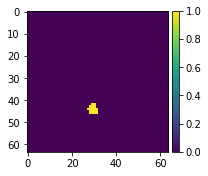

In [31]:
plt.figure(figsize=(s,s))
io.imshow(labels[ind][0].numpy())

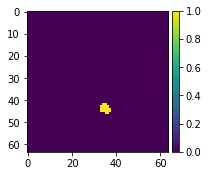

In [32]:
plt.figure(figsize=(s,s))
io.imshow(labels0[ind][0].numpy())

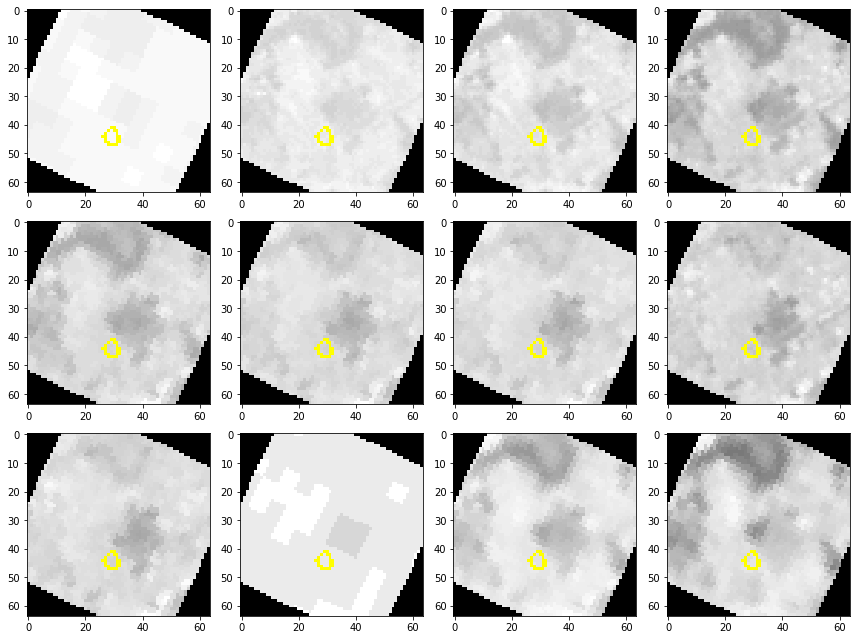

In [33]:
fig, axes = plt.subplots(3, 4, figsize=(s*4, s*3))
for ax, img in zip(axes.ravel(), imgs[ind]):
  plt.sca(ax)
  im = img.numpy()
  im = im / np.max(im)
  io.imshow(mark_boundaries(im, labels[ind][0].numpy(), 
                            mode='outer'))

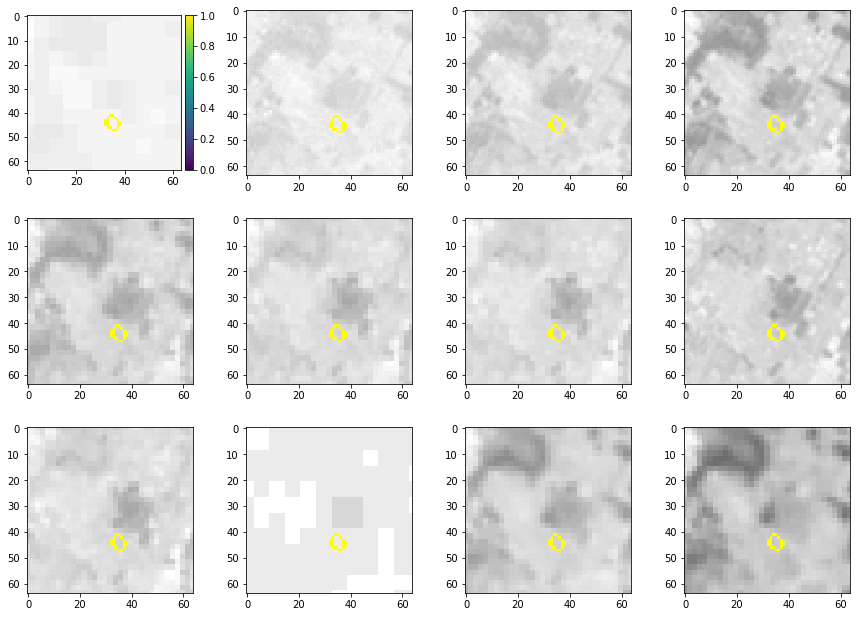

In [34]:
fig, axes = plt.subplots(3, 4, figsize=(s*4, s*3))
for ax, img in zip(axes.ravel(), imgs0[ind]):
  plt.sca(ax)
  im = img.numpy()
  im = im / np.max(im)
  io.imshow(mark_boundaries(im, labels0[ind][0].numpy(), 
                            mode='outer'))

### Specify the loaders

In [35]:
np.random.seed(random_seed)

dl_train = torch.utils.data.DataLoader(
    AgriDataset(df_train, size=size,
                transforms=train_transforms
                ), 
    shuffle=True, batch_size=batch_size, num_workers=2
    )
dl_val = torch.utils.data.DataLoader(
    AgriDataset(df_val, size=size,
                transforms=validation_transforms
                ), 
    shuffle=False, batch_size=batch_size, num_workers=2
    )

## Specify the training pipeline

### Parameters

In [36]:
out_channels = int(np.max(crop_labels) + 1)
n_channels = (32, 64, 128, 256, 512, 512)
strides = (1, 2, 1, 2, 2)
num_res_units = 3
lr = 0.0001
weight_decay = 0.0005
factor = 0.1
patience = 5
epochs = 100

### Model and loss

In [37]:
net = UNet(
    spatial_dims=2,
    in_channels=len(BAND_NAMES),
    out_channels=out_channels,
    channels=n_channels,
    strides=strides,
    num_res_units=num_res_units,
    norm=Norm.BATCH,
).cuda()

In [38]:
# class MaskedDiceCELoss(nn.Module):

#   def __init__(self, include_background=False, to_onehot_y=True, softmax=True,
#                dice_ce_weight=1, dice_mask_weight=1):
    
#     super().__init__()
#     self.diceCELoss = DiceCELoss(include_background=include_background, 
#                                  to_onehot_y=to_onehot_y, 
#                                  softmax=softmax)
#     self.diceMasked = MaskedDiceLoss(include_background=include_background, 
#                                        to_onehot_y=to_onehot_y, 
#                                        softmax=softmax)
#     self.dice_ce_weight = dice_ce_weight
#     self.dice_mask_weight = dice_mask_weight

#   def forward(self, input, target, mask):
#     loss1 = self.diceCELoss(input, target)*self.dice_ce_weight 
#     loss2 = self.diceMasked(input, target, mask)*self.dice_mask_weight
#     return loss1 + loss2

In [39]:
# loss_fn = MaskedDiceCELoss(include_background=False, 
#                            to_onehot_y=True, softmax=True).cuda()
loss_fn = DiceCELoss(include_background=True,
                     to_onehot_y=True, softmax=True,
                     ce_weight=torch.tensor(loss_weights).float()).cuda()
metric = DiceMetric(include_background=False, reduction="mean")

### Optimizer and scheduler

In [40]:
optimizer = torch.optim.AdamW(
    params=[{"params": [p for p in net.parameters() if p.requires_grad]}],
            lr=lr, weight_decay=weight_decay
            )

In [41]:
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=factor, patience=patience
    )

### Training step

In [42]:
def train_epoch(net, loss_fn, dl_train, optimizer):
  net.train()
  loss_fn.train()
  epoch_loss = 0
  step = 0
  for imgs, targets in tqdm(dl_train):
    step += 1
    optimizer.zero_grad()
    outputs = net(imgs.cuda())
    losses = loss_fn(outputs, targets.cuda())
    losses.backward()
    optimizer.step()
    epoch_loss += losses.item()
  epoch_loss /= step
  return epoch_loss

### Validation step

In [43]:
def validate_epoch(net, loss_fn, dl_val, metric):
  net.eval()
  loss_fn.eval()
  epoch_loss = 0
  step = 0

  with torch.no_grad():
    for imgs, targets in tqdm(dl_val):
      step += 1
      outputs = net(imgs.cuda())
      losses = loss_fn(outputs, targets.cuda())
      epoch_loss += losses.item()
      metric(outputs.argmax(1).unsqueeze(1), targets.cuda())
  epoch_loss /= step
  return epoch_loss, metric

## Train the model

In [44]:
%%time
best_metric = 0
train_losses = []
val_losses = []
val_metrics = []
for epoch in range(epochs):
    # training pass
    train_loss = train_epoch(net, loss_fn, dl_train, optimizer)

    # validation pass
    val_loss, metric = validate_epoch(net, loss_fn, dl_val, metric)
    val_metric = metric.aggregate().item()
    metric.reset()

    # update learning rate
    lr_scheduler.step(val_loss)

    # output
    print(f"epoch {epoch + 1} training loss: {train_loss:.4f}; "
          f"validation loss: {val_loss:.4f}; Dice metric: {val_metric:.4f}; "
          f"lr: {optimizer.param_groups[0]['lr']}")
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_metrics.append(val_metric)
    if val_metric >= best_metric:
      best_metric = val_metric
      torch.save(net.state_dict(), 'model.pth')
      print('saving best model')

  0%|          | 0/73 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/monai/metrics/utils.py:219: UserWarning: y_pred should be a binarized tensor.
  warnings.warn(f"{name} should be a binarized tensor.")
/usr/local/lib/python3.7/dist-packages/monai/metrics/utils.py:219: UserWarning: y should be a binarized tensor.
  warnings.warn(f"{name} should be a binarized tensor.")
100%|██████████| 73/73 [00:31<00:00,  2.34it/s]


epoch 1 training loss: 3.4519; validation loss: 3.0611; Dice metric: 0.1798; lr: 0.0001
saving best model


100%|██████████| 73/73 [00:31<00:00,  2.34it/s]


epoch 2 training loss: 2.9470; validation loss: 2.9078; Dice metric: 0.1917; lr: 0.0001
saving best model


100%|██████████| 73/73 [00:31<00:00,  2.32it/s]


epoch 3 training loss: 2.8390; validation loss: 2.7683; Dice metric: 0.1726; lr: 0.0001


100%|██████████| 73/73 [00:31<00:00,  2.31it/s]


epoch 4 training loss: 2.7865; validation loss: 2.9149; Dice metric: 0.1768; lr: 0.0001


100%|██████████| 73/73 [00:31<00:00,  2.32it/s]


epoch 5 training loss: 2.7162; validation loss: 2.7235; Dice metric: 0.1900; lr: 0.0001


100%|██████████| 73/73 [00:31<00:00,  2.31it/s]


epoch 6 training loss: 2.6925; validation loss: 2.6792; Dice metric: 0.1862; lr: 0.0001


100%|██████████| 73/73 [00:31<00:00,  2.33it/s]


epoch 7 training loss: 2.6575; validation loss: 2.7460; Dice metric: 0.1843; lr: 0.0001


100%|██████████| 73/73 [00:31<00:00,  2.34it/s]


epoch 8 training loss: 2.6504; validation loss: 2.9263; Dice metric: 0.1897; lr: 0.0001


100%|██████████| 73/73 [00:31<00:00,  2.33it/s]


epoch 9 training loss: 2.6112; validation loss: 2.6731; Dice metric: 0.1939; lr: 0.0001
saving best model


100%|██████████| 73/73 [00:31<00:00,  2.33it/s]


epoch 10 training loss: 2.6146; validation loss: 2.7125; Dice metric: 0.1960; lr: 0.0001
saving best model


100%|██████████| 73/73 [00:31<00:00,  2.33it/s]


epoch 11 training loss: 2.5898; validation loss: 2.6306; Dice metric: 0.1927; lr: 0.0001


100%|██████████| 73/73 [00:31<00:00,  2.32it/s]


epoch 12 training loss: 2.5513; validation loss: 2.7871; Dice metric: 0.1989; lr: 0.0001
saving best model


100%|██████████| 73/73 [00:31<00:00,  2.32it/s]


epoch 13 training loss: 2.5547; validation loss: 2.6993; Dice metric: 0.1894; lr: 0.0001


100%|██████████| 73/73 [00:31<00:00,  2.34it/s]


epoch 14 training loss: 2.5176; validation loss: 2.6021; Dice metric: 0.1831; lr: 0.0001


100%|██████████| 73/73 [00:31<00:00,  2.35it/s]


epoch 15 training loss: 2.5148; validation loss: 2.5819; Dice metric: 0.1833; lr: 0.0001


100%|██████████| 73/73 [00:31<00:00,  2.35it/s]


epoch 16 training loss: 2.5115; validation loss: 2.6570; Dice metric: 0.1897; lr: 0.0001


100%|██████████| 73/73 [00:31<00:00,  2.33it/s]


epoch 17 training loss: 2.4571; validation loss: 2.5313; Dice metric: 0.1991; lr: 0.0001
saving best model


100%|██████████| 73/73 [00:31<00:00,  2.35it/s]


epoch 18 training loss: 2.4575; validation loss: 2.8544; Dice metric: 0.1971; lr: 0.0001


100%|██████████| 73/73 [00:31<00:00,  2.32it/s]


epoch 19 training loss: 2.4478; validation loss: 2.4988; Dice metric: 0.1956; lr: 0.0001


100%|██████████| 73/73 [00:31<00:00,  2.34it/s]


epoch 20 training loss: 2.4270; validation loss: 2.8443; Dice metric: 0.1867; lr: 0.0001


100%|██████████| 73/73 [00:31<00:00,  2.31it/s]


epoch 21 training loss: 2.4210; validation loss: 2.5643; Dice metric: 0.1953; lr: 0.0001


100%|██████████| 73/73 [00:31<00:00,  2.34it/s]


epoch 22 training loss: 2.4555; validation loss: 2.4829; Dice metric: 0.1944; lr: 0.0001


100%|██████████| 73/73 [00:30<00:00,  2.36it/s]


epoch 23 training loss: 2.3798; validation loss: 2.4743; Dice metric: 0.1990; lr: 0.0001


100%|██████████| 73/73 [00:31<00:00,  2.34it/s]


epoch 24 training loss: 2.3553; validation loss: 2.6511; Dice metric: 0.2000; lr: 0.0001
saving best model


100%|██████████| 73/73 [00:30<00:00,  2.36it/s]


epoch 25 training loss: 2.3841; validation loss: 2.6007; Dice metric: 0.1960; lr: 0.0001


100%|██████████| 73/73 [00:31<00:00,  2.35it/s]


epoch 26 training loss: 2.3752; validation loss: 2.6023; Dice metric: 0.1979; lr: 0.0001


100%|██████████| 73/73 [00:31<00:00,  2.31it/s]


epoch 27 training loss: 2.3635; validation loss: 2.6637; Dice metric: 0.1977; lr: 0.0001


100%|██████████| 73/73 [00:32<00:00,  2.25it/s]


epoch 28 training loss: 2.3402; validation loss: 2.6553; Dice metric: 0.2024; lr: 0.0001
saving best model


100%|██████████| 73/73 [00:32<00:00,  2.26it/s]


epoch 29 training loss: 2.2918; validation loss: 2.3701; Dice metric: 0.1978; lr: 0.0001


100%|██████████| 73/73 [00:32<00:00,  2.26it/s]


epoch 30 training loss: 2.3361; validation loss: 2.3888; Dice metric: 0.2100; lr: 0.0001
saving best model


100%|██████████| 73/73 [00:31<00:00,  2.35it/s]


epoch 31 training loss: 2.3107; validation loss: 2.4098; Dice metric: 0.1979; lr: 0.0001


100%|██████████| 73/73 [00:30<00:00,  2.36it/s]


epoch 32 training loss: 2.2784; validation loss: 2.5164; Dice metric: 0.2092; lr: 0.0001


100%|██████████| 73/73 [00:31<00:00,  2.35it/s]


epoch 33 training loss: 2.2897; validation loss: 2.4350; Dice metric: 0.2028; lr: 0.0001


100%|██████████| 73/73 [00:31<00:00,  2.34it/s]


epoch 34 training loss: 2.2193; validation loss: 2.3225; Dice metric: 0.2069; lr: 0.0001


100%|██████████| 73/73 [00:31<00:00,  2.35it/s]


epoch 35 training loss: 2.2826; validation loss: 2.5258; Dice metric: 0.2055; lr: 0.0001


100%|██████████| 73/73 [00:30<00:00,  2.36it/s]


epoch 36 training loss: 2.2300; validation loss: 2.3174; Dice metric: 0.2118; lr: 0.0001
saving best model


100%|██████████| 73/73 [00:31<00:00,  2.34it/s]


epoch 37 training loss: 1.8713; validation loss: 1.7989; Dice metric: 0.2040; lr: 0.0001


100%|██████████| 73/73 [00:31<00:00,  2.34it/s]


epoch 38 training loss: 1.5923; validation loss: 1.9222; Dice metric: 0.2010; lr: 0.0001


100%|██████████| 73/73 [00:31<00:00,  2.35it/s]


epoch 39 training loss: 1.5464; validation loss: 2.7860; Dice metric: 0.2104; lr: 0.0001


100%|██████████| 73/73 [00:32<00:00,  2.26it/s]


epoch 40 training loss: 1.5473; validation loss: 1.6638; Dice metric: 0.2115; lr: 0.0001


100%|██████████| 73/73 [00:32<00:00,  2.27it/s]


epoch 41 training loss: 1.5712; validation loss: 1.7135; Dice metric: 0.2010; lr: 0.0001


100%|██████████| 73/73 [00:30<00:00,  2.36it/s]


epoch 42 training loss: 1.5700; validation loss: 1.9175; Dice metric: 0.2013; lr: 0.0001


100%|██████████| 73/73 [00:31<00:00,  2.35it/s]


epoch 43 training loss: 1.5159; validation loss: 2.1873; Dice metric: 0.1942; lr: 0.0001


100%|██████████| 73/73 [00:31<00:00,  2.35it/s]


epoch 44 training loss: 1.5173; validation loss: 1.8955; Dice metric: 0.2082; lr: 0.0001


100%|██████████| 73/73 [00:31<00:00,  2.34it/s]


epoch 45 training loss: 1.5064; validation loss: 2.0044; Dice metric: 0.2085; lr: 0.0001


100%|██████████| 73/73 [00:31<00:00,  2.35it/s]


epoch 46 training loss: 1.4983; validation loss: 1.8608; Dice metric: 0.1865; lr: 1e-05


100%|██████████| 73/73 [00:31<00:00,  2.35it/s]


epoch 47 training loss: 1.4191; validation loss: 1.4874; Dice metric: 0.2083; lr: 1e-05


100%|██████████| 73/73 [00:32<00:00,  2.25it/s]


epoch 48 training loss: 1.4020; validation loss: 1.4550; Dice metric: 0.2119; lr: 1e-05
saving best model


100%|██████████| 73/73 [00:31<00:00,  2.34it/s]


epoch 49 training loss: 1.3739; validation loss: 1.4509; Dice metric: 0.2128; lr: 1e-05
saving best model


100%|██████████| 73/73 [00:31<00:00,  2.34it/s]


epoch 50 training loss: 1.3660; validation loss: 1.4454; Dice metric: 0.2127; lr: 1e-05


100%|██████████| 73/73 [00:31<00:00,  2.34it/s]


epoch 51 training loss: 1.3368; validation loss: 1.4610; Dice metric: 0.2102; lr: 1e-05


100%|██████████| 73/73 [00:32<00:00,  2.26it/s]


epoch 52 training loss: 1.3615; validation loss: 1.4721; Dice metric: 0.2108; lr: 1e-05


100%|██████████| 73/73 [00:31<00:00,  2.33it/s]


epoch 53 training loss: 1.3223; validation loss: 1.4394; Dice metric: 0.2120; lr: 1e-05


100%|██████████| 73/73 [00:32<00:00,  2.26it/s]


epoch 54 training loss: 1.3769; validation loss: 1.4319; Dice metric: 0.2155; lr: 1e-05
saving best model


100%|██████████| 73/73 [00:32<00:00,  2.27it/s]


epoch 55 training loss: 1.3316; validation loss: 1.4282; Dice metric: 0.2152; lr: 1e-05


100%|██████████| 73/73 [00:31<00:00,  2.33it/s]


epoch 56 training loss: 1.3236; validation loss: 1.4145; Dice metric: 0.2154; lr: 1e-05


100%|██████████| 73/73 [00:31<00:00,  2.34it/s]


epoch 57 training loss: 1.2995; validation loss: 1.4339; Dice metric: 0.2129; lr: 1e-05


100%|██████████| 73/73 [00:31<00:00,  2.33it/s]


epoch 58 training loss: 1.3313; validation loss: 1.4086; Dice metric: 0.2185; lr: 1e-05
saving best model


100%|██████████| 73/73 [00:30<00:00,  2.36it/s]


epoch 59 training loss: 1.3305; validation loss: 1.4274; Dice metric: 0.2170; lr: 1e-05


100%|██████████| 73/73 [00:32<00:00,  2.27it/s]


epoch 60 training loss: 1.3206; validation loss: 1.3994; Dice metric: 0.2172; lr: 1e-05


100%|██████████| 73/73 [00:30<00:00,  2.36it/s]


epoch 61 training loss: 1.3099; validation loss: 1.4364; Dice metric: 0.2176; lr: 1e-05


100%|██████████| 73/73 [00:30<00:00,  2.36it/s]


epoch 62 training loss: 1.2953; validation loss: 1.3991; Dice metric: 0.2176; lr: 1e-05


100%|██████████| 73/73 [00:31<00:00,  2.33it/s]


epoch 63 training loss: 1.3112; validation loss: 1.3988; Dice metric: 0.2168; lr: 1e-05


100%|██████████| 73/73 [00:31<00:00,  2.33it/s]


epoch 64 training loss: 1.2943; validation loss: 1.4013; Dice metric: 0.2172; lr: 1e-05


100%|██████████| 73/73 [00:32<00:00,  2.26it/s]


epoch 65 training loss: 1.3160; validation loss: 1.4208; Dice metric: 0.2166; lr: 1e-05


100%|██████████| 73/73 [00:31<00:00,  2.34it/s]


epoch 66 training loss: 1.2900; validation loss: 1.3805; Dice metric: 0.2162; lr: 1e-05


100%|██████████| 73/73 [00:31<00:00,  2.34it/s]


epoch 67 training loss: 1.2917; validation loss: 1.4183; Dice metric: 0.2168; lr: 1e-05


100%|██████████| 73/73 [00:30<00:00,  2.36it/s]


epoch 68 training loss: 1.2936; validation loss: 1.4057; Dice metric: 0.2179; lr: 1e-05


100%|██████████| 73/73 [00:32<00:00,  2.26it/s]


epoch 69 training loss: 1.2913; validation loss: 1.3734; Dice metric: 0.2201; lr: 1e-05
saving best model


100%|██████████| 73/73 [00:31<00:00,  2.34it/s]


epoch 70 training loss: 1.2778; validation loss: 1.3744; Dice metric: 0.2194; lr: 1e-05


100%|██████████| 73/73 [00:31<00:00,  2.33it/s]


epoch 71 training loss: 1.2893; validation loss: 1.4283; Dice metric: 0.2144; lr: 1e-05


100%|██████████| 73/73 [00:31<00:00,  2.33it/s]


epoch 72 training loss: 1.2617; validation loss: 1.3743; Dice metric: 0.2161; lr: 1e-05


100%|██████████| 73/73 [00:32<00:00,  2.23it/s]


epoch 73 training loss: 1.2608; validation loss: 1.3828; Dice metric: 0.2165; lr: 1e-05


100%|██████████| 73/73 [00:31<00:00,  2.34it/s]


epoch 74 training loss: 1.2683; validation loss: 1.3580; Dice metric: 0.2197; lr: 1e-05


100%|██████████| 73/73 [00:31<00:00,  2.34it/s]


epoch 75 training loss: 1.2767; validation loss: 1.3819; Dice metric: 0.2199; lr: 1e-05


100%|██████████| 73/73 [00:31<00:00,  2.34it/s]


epoch 76 training loss: 1.2643; validation loss: 1.3691; Dice metric: 0.2200; lr: 1e-05


100%|██████████| 73/73 [00:32<00:00,  2.26it/s]


epoch 77 training loss: 1.2565; validation loss: 1.3762; Dice metric: 0.2162; lr: 1e-05


100%|██████████| 73/73 [00:31<00:00,  2.33it/s]


epoch 78 training loss: 1.2680; validation loss: 1.3570; Dice metric: 0.2175; lr: 1e-05


100%|██████████| 73/73 [00:31<00:00,  2.34it/s]


epoch 79 training loss: 1.2853; validation loss: 1.3666; Dice metric: 0.2182; lr: 1e-05


100%|██████████| 73/73 [00:31<00:00,  2.33it/s]


epoch 80 training loss: 1.2605; validation loss: 1.3780; Dice metric: 0.2182; lr: 1e-05


100%|██████████| 73/73 [00:32<00:00,  2.26it/s]


epoch 81 training loss: 1.2383; validation loss: 1.3644; Dice metric: 0.2186; lr: 1e-05


100%|██████████| 73/73 [00:31<00:00,  2.35it/s]


epoch 82 training loss: 1.2472; validation loss: 1.3568; Dice metric: 0.2174; lr: 1e-05


100%|██████████| 73/73 [00:31<00:00,  2.35it/s]


epoch 83 training loss: 1.2590; validation loss: 1.3582; Dice metric: 0.2187; lr: 1e-05


100%|██████████| 73/73 [00:30<00:00,  2.36it/s]


epoch 84 training loss: 1.2640; validation loss: 1.3523; Dice metric: 0.2167; lr: 1e-05


100%|██████████| 73/73 [00:32<00:00,  2.25it/s]


epoch 85 training loss: 1.2467; validation loss: 1.3348; Dice metric: 0.2206; lr: 1e-05
saving best model


100%|██████████| 73/73 [00:30<00:00,  2.36it/s]


epoch 86 training loss: 1.2550; validation loss: 1.3443; Dice metric: 0.2179; lr: 1e-05


100%|██████████| 73/73 [00:31<00:00,  2.34it/s]


epoch 87 training loss: 1.2409; validation loss: 1.3364; Dice metric: 0.2178; lr: 1e-05


100%|██████████| 73/73 [00:31<00:00,  2.34it/s]


epoch 88 training loss: 1.2216; validation loss: 1.3515; Dice metric: 0.2187; lr: 1e-05


100%|██████████| 73/73 [00:31<00:00,  2.35it/s]


epoch 89 training loss: 1.2465; validation loss: 1.3522; Dice metric: 0.2171; lr: 1e-05


100%|██████████| 73/73 [00:32<00:00,  2.26it/s]


epoch 90 training loss: 1.2572; validation loss: 1.3379; Dice metric: 0.2229; lr: 1e-05
saving best model


100%|██████████| 73/73 [00:31<00:00,  2.34it/s]


epoch 91 training loss: 1.2384; validation loss: 1.3546; Dice metric: 0.2185; lr: 1.0000000000000002e-06


100%|██████████| 73/73 [00:30<00:00,  2.36it/s]


epoch 92 training loss: 1.2091; validation loss: 1.3431; Dice metric: 0.2187; lr: 1.0000000000000002e-06


100%|██████████| 73/73 [00:31<00:00,  2.34it/s]


epoch 93 training loss: 1.2080; validation loss: 1.3385; Dice metric: 0.2185; lr: 1.0000000000000002e-06


100%|██████████| 73/73 [00:31<00:00,  2.34it/s]


epoch 94 training loss: 1.2164; validation loss: 1.3296; Dice metric: 0.2228; lr: 1.0000000000000002e-06


100%|██████████| 73/73 [00:32<00:00,  2.26it/s]


epoch 95 training loss: 1.2318; validation loss: 1.3431; Dice metric: 0.2194; lr: 1.0000000000000002e-06


100%|██████████| 73/73 [00:31<00:00,  2.34it/s]


epoch 96 training loss: 1.1983; validation loss: 1.3406; Dice metric: 0.2211; lr: 1.0000000000000002e-06


100%|██████████| 73/73 [00:34<00:00,  2.12it/s]


epoch 97 training loss: 1.2047; validation loss: 1.3337; Dice metric: 0.2209; lr: 1.0000000000000002e-06


100%|██████████| 73/73 [00:34<00:00,  2.14it/s]


epoch 98 training loss: 1.2232; validation loss: 1.3217; Dice metric: 0.2216; lr: 1.0000000000000002e-06


100%|██████████| 73/73 [00:33<00:00,  2.19it/s]


epoch 99 training loss: 1.2094; validation loss: 1.3224; Dice metric: 0.2184; lr: 1.0000000000000002e-06


100%|██████████| 73/73 [00:31<00:00,  2.29it/s]

epoch 100 training loss: 1.2023; validation loss: 1.3252; Dice metric: 0.2187; lr: 1.0000000000000002e-06
CPU times: user 42min 25s, sys: 1min 32s, total: 43min 57s
Wall time: 4h 46min 41s


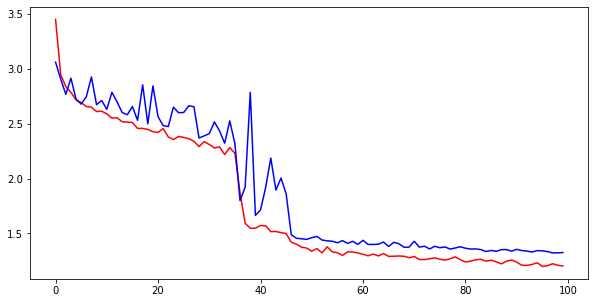

In [45]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses,'r')
plt.plot(val_losses, 'b')

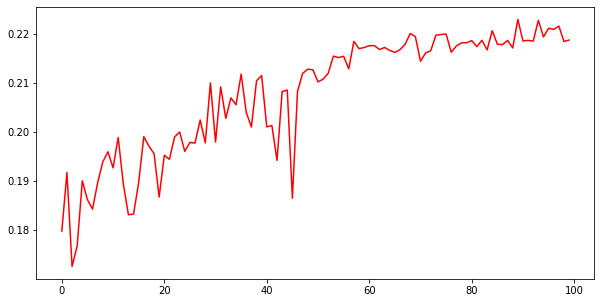

In [46]:
plt.figure(figsize=(10, 5))
plt.plot(val_metrics,'r')

## Set up the loaders and model for evaluation

In [47]:
class AgriDatasetTest(torch.utils.data.Dataset):

  def __init__(self, df, band_names=BAND_NAMES, size=64):
    self.band_names = band_names
    self.df = df
    self.size = size

  def __getitem__(self, index):
    imgs = []
    for band in self.band_names:
      source_fn = rf"{self.df.iloc[index]['source_path']}{band}.tif"
      with rasterio.open(source_fn) as src:
        imgs.append(src.read()[0].astype(np.float64)/255.)

    with rasterio.open(self.df.iloc[index]['field_path']) as src:
      labels = src.read()[0].astype(np.int64)

    labels = torch.tensor(labels)
    imgs = torch.tensor(np.array(imgs))

    hs = int(self.size/2)
    ind = [self.df.iloc[index]['center_y'], self.df.iloc[index]['center_x']]
    ind = np.max(np.array([[hs, hs], ind]), axis=0)
    ind = np.int_(np.min(np.array([np.array(imgs.shape[-2:])-hs-1, ind]), axis=0))

    imgs = imgs[:, ind[0]-hs:ind[0]+hs, ind[1]-hs:ind[1]+hs]
    labels = labels[ind[0]-hs:ind[0]+hs, ind[1]-hs:ind[1]+hs]

    if 'label_path' in self.df.columns and os.path.exists(self.df.iloc[index]['label_path']):
      with rasterio.open(self.df.iloc[index]['label_path']) as src:
        gt = src.read()[0].astype(np.int64)
        gt = torch.tensor(gt)[ind[0]-hs:ind[0]+hs, ind[1]-hs:ind[1]+hs]
    else:
      gt = labels


    return imgs.float(), labels, gt

  def __len__(self):
    return len(self.df)

In [48]:
dl_test = torch.utils.data.DataLoader(
    AgriDatasetTest(df_val),
    shuffle=False, batch_size=batch_size, num_workers=2
    )

In [49]:
net.load_state_dict(torch.load('model.pth'))
net.eval();

## Evaluate the model on the validation set

In [50]:
def evaluate(dl_test, net):
  field_data = dict()
  gt_labels = dict()
  with torch.no_grad():
    for imgs, labels, gt in tqdm(dl_test):
      output = net(imgs.cuda()).cpu()
      output = output.numpy()
      labels = labels.numpy()
      output = np.moveaxis(output, 1, -1)

      llist = np.unique(labels)[1:]
      for lb in llist:
        ind = np.where(labels == lb)
        data = output[ind]
        if lb in field_data.keys():
          field_data[lb] = np.concatenate([field_data[lb], data], axis=0)
        else:
          field_data[lb] = data

        data = gt[ind]
        if lb in gt_labels.keys():
          gt_labels[lb] = np.concatenate([gt_labels[lb], data], axis=0)
        else:
          gt_labels[lb] = data
        
  field_ids = []
  probs = []
  gt = []
  for key in field_data.keys():
    field_ids.append(key)
    prob = field_data[key].mean(0)[list(np.int_(crop_labels))]
    prob = prob - np.min(prob)
    prob = prob / np.sum(prob)
    probs.append(prob)
    gt.append(gt_labels[key][0].item())
  probs = np.array(probs)
  return probs, field_ids, gt

In [51]:
probs, field_ids, gt = evaluate(dl_test, net)

100%|██████████| 73/73 [00:35<00:00,  2.08it/s]


In [52]:
from sklearn.metrics import classification_report

print(classification_report(gt, np.array(crop_labels)[np.argmax(probs, axis=1)]))

              precision    recall  f1-score   support

           1       0.81      0.46      0.59      1104
           2       0.57      0.29      0.38       524
           3       0.11      0.63      0.19        52
           4       0.94      0.53      0.67      1034
           5       0.13      0.85      0.23        13
           6       0.16      0.84      0.27        79
           8       0.17      0.77      0.28        26
           9       0.60      0.89      0.71       134
          13       0.28      0.73      0.40        30
          14       0.15      0.89      0.26         9
          15       0.11      0.56      0.18        16
          16       0.14      1.00      0.24         6
          36       0.24      0.80      0.37        74

    accuracy                           0.50      3101
   macro avg       0.34      0.71      0.37      3101
weighted avg       0.74      0.50      0.56      3101



In [53]:
def to_one_hot(x):
    y = np.zeros((x.size, x.max() + 1))
    y[np.arange(x.size), x] = 1
    return y

def cross_entropy(predictions, targets):
    return -np.sum(np.sum(np.log(predictions + 10**(-10)) * targets, axis=1))/len(targets)


In [54]:
targets = to_one_hot(np.array(gt))
targets = targets[:, np.where(targets.sum(axis=0) > 0)[0]]

In [55]:
cross_entropy(probs, targets)

1.8860958520153652

## Prepare the test dataset

In [56]:
test_paths = os.listdir(os.path.join(data_dir, test_label_collection))
test_ids = [fn.split('_')[-1] for fn in test_paths if 'labels_test' in fn]

field_paths = [f'{data_dir}/{test_label_collection}/{test_label_collection}_{i}/field_ids.tif' 
               for i in test_ids]
label_paths = [f'{data_dir}/{test_label_collection}/{test_label_collection}_{i}/raster_labels.tif' 
               for i in test_ids]
source_paths = [f'{data_dir}/{source_collection}/{source_collection}_{i}/' 
               for i in test_ids]

In [57]:
test_data = pd.DataFrame(np.array([test_ids, field_paths, label_paths, source_paths]).transpose(), 
                          columns=['folder_id', 'field_path', 'label_path', 'source_path'])
test_data.head()

,folder_id,field_path,label_path,source_path
0,1cf43,data/ref_agrifieldnet_competition_v1_labels_te...,data/ref_agrifieldnet_competition_v1_labels_te...,data/ref_agrifieldnet_competition_v1_source/re...
1,86e43,data/ref_agrifieldnet_competition_v1_labels_te...,data/ref_agrifieldnet_competition_v1_labels_te...,data/ref_agrifieldnet_competition_v1_source/re...
2,15785,data/ref_agrifieldnet_competition_v1_labels_te...,data/ref_agrifieldnet_competition_v1_labels_te...,data/ref_agrifieldnet_competition_v1_source/re...
3,7ee61,data/ref_agrifieldnet_competition_v1_labels_te...,data/ref_agrifieldnet_competition_v1_labels_te...,data/ref_agrifieldnet_competition_v1_source/re...
4,06d05,data/ref_agrifieldnet_competition_v1_labels_te...,data/ref_agrifieldnet_competition_v1_labels_te...,data/ref_agrifieldnet_competition_v1_source/re...


In [58]:
def extract_field_crop_data_test(data):
  field_ids = []
  field_center_x = []
  field_center_y = []
  field_paths = []
  source_paths = []

  for i in tqdm(range(len(data))):
      with rasterio.open(data['field_path'].iloc[i]) as src:
          field_data = src.read()[0]

      for field_id in np.unique(field_data)[1:]:
          ind = np.where(field_data == field_id)
          field_ids.append(field_id)
          field_center_y.append(np.mean(ind[0]))
          field_center_x.append(np.mean(ind[1]))
          field_paths.append(data['field_path'].iloc[i])
          source_paths.append(data['source_path'].iloc[i])

  df = pd.DataFrame(np.array([field_ids, field_center_x, 
                              field_center_y]).transpose(),
                    columns=['field_id', 'center_x', 'center_y'])
  df['field_path'] = field_paths
  df['source_path'] = source_paths
  return df

In [59]:
test_df = extract_field_crop_data_test(test_data)

100%|██████████| 707/707 [00:02<00:00, 281.50it/s]


## Evaluate the model on the test set

In [60]:
dl_test = torch.utils.data.DataLoader(
    AgriDatasetTest(test_df), shuffle=False, batch_size=batch_size, num_workers=2
    )

In [61]:
probs, field_ids, gt = evaluate(dl_test, net)

100%|██████████| 101/101 [00:43<00:00,  2.31it/s]


In [62]:
def labeler(labeled):
    crop_label = np.array([crop_dict.get(f'{int(i)}') for i in labeled])
    return crop_label

In [63]:
crop_columns = [crop_dict[key] for key in crop_labels]

output_df  = pd.DataFrame(columns=['field_id'] + crop_columns)

output_df['field_id'] = field_ids

output_df[crop_columns] = probs 
output_df.to_csv('submission.csv', index=False)

In [64]:
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>